In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz

import rdata

## Oceanic Technology

data(Kline2)

Number of tools types associated with population size

Spatial covariation: Islands close together share unobserved confounds and innovations

P: Population

T: Tools

C: COntact

U: Unobserved confounds

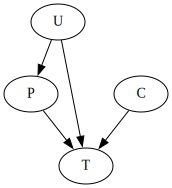

In [2]:
ot = graphviz.Digraph()
ot.edge('P','T')
ot.edge('U','P')
ot.edge('U','T')
ot.edge('C','T')
ot

$\Delta T = \alpha  P^{\beta} - \gamma T$

$T_{i} \sim Poisson(\lambda _i)$

$\lambda _i = \hat{T}$

$\hat{T} = \frac{\alpha P^{\beta}}{\gamma}$

$T_{i} \sim Poisson(\lambda_i)$

$\log{\lambda_i} = \bar{\alpha} + \alpha_{S[i]}$

$[\alpha_1,\alpha_2,\alpha_3,...,\alpha_{10}] \sim MVNormal([0,0,0,...,0], K)$

Going to model covariance of distance between islands. 

## Gaussian Processes

A Gaussian Process is "an infinite dimensional generalization of multivariate normal distributions"

What does this mean?

Instead of conventional covariance matrix, use a kernel function that generalizes to infinite dimensions/observations/predictions

The covariances matrix can get arbitrarily large. 

Instead of conventional covariance matrix, use a kernel function

The kernel gives the covariance between any pair of points as a funciton of their distances

Distance can be difference, space, time, etc. 

Continuous, ordered categories

Want to do partial pooling with regards to "distance"

We learn the covariance kernel from the sample 

Common kernels:

- Quadratic (L2) #L2norm,gaussian

- Ornstein-Uhlenbeck #Declines exponentialls, 

- Periodic 

$k_{i,j} = \eta^2exp(-\rho^2d^{2}_{i,j})$

$\bar{\alpha} \sim Normal(3,0.5)$

$\eta^2 \sim Exponential(2)$

$\rho^2 \sim Exponential(0.5)$

In [3]:
kline2 = pd.read_csv('Data/kline2.csv',sep=';')
kline2.head()

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235


In [151]:
parsed = rdata.parser.parse_file('Data/islandsDistMatrix.rda')
converted = rdata.conversion.convert(parsed)
islandsDistMatrix = converted['islandsDistMatrix']
islandsDistMatrix

<xarray.DataArray (dim_0: 10, dim_1: 10)>
array([[0.   , 0.475, 0.631, 4.363, 1.234, 2.036, 3.178, 2.794, 1.86 ,
        5.678],
       [0.475, 0.   , 0.315, 4.173, 1.236, 2.007, 2.877, 2.67 , 1.965,
        5.283],
       [0.631, 0.315, 0.   , 3.859, 1.55 , 1.708, 2.588, 2.356, 2.279,
        5.401],
       [4.363, 4.173, 3.859, 0.   , 5.391, 2.462, 1.555, 1.616, 6.136,
        7.178],
       [1.234, 1.236, 1.55 , 5.391, 0.   , 3.219, 4.027, 3.906, 0.763,
        4.884],
       [2.036, 2.007, 1.708, 2.462, 3.219, 0.   , 1.801, 0.85 , 3.893,
        6.653],
       [3.178, 2.877, 2.588, 1.555, 4.027, 1.801, 0.   , 1.213, 4.789,
        5.787],
       [2.794, 2.67 , 2.356, 1.616, 3.906, 0.85 , 1.213, 0.   , 4.622,
        6.722],
       [1.86 , 1.965, 2.279, 6.136, 0.763, 3.893, 4.789, 4.622, 0.   ,
        5.037],
       [5.678, 5.283, 5.401, 7.178, 4.884, 6.653, 5.787, 6.722, 5.037,
        0.   ]])
Coordinates:
  * dim_0    (dim_0) <U10 'Malekula' 'Tikopia' 'Santa Cruz' ... 'Tonga' 'Hawaii'
  * dim_1    (dim_1) <U10 'Malekula' 'Tikopia' 'Santa Cruz' ... 'Tonga' 'Hawaii'

In [5]:
with pm.Model() as mTdist:
    
    T = pm.MutableData('T',kline2['total_tools'].values)
    S = pm.MutableData('S',np.arange(0,10))
    D = pm.MutableData('D',islandsDistMatrix.values)
    
    etasq = pm.Exponential('etasq',2)
    ls_inv = pm.HalfNormal("ls_inv",2.0)
    rhosq = pm.Deterministic('rhosq',0.5 * ls_inv**2)
    
    abar = pm.Normal('abar',3,0.5)
    
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1,ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov) #also GP or gp in other notes/docs 
    a = gp.prior("a", X=D) #MVNormal 
    
    lam = abar + a[S]
    
    Tobs = pm.Poisson('Tobs',pt.exp(lam),observed=T)
    
    mTdist_trace = pm.sample(4000, tune=2000, target_accept=0.99)

G:\Statistical_Rethinking\rethinking\Lib\site-packages\pymc\gp\cov.py:99: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 168 seconds.


In [6]:
az.summary(mTdist_trace, var_names=["~a_rotated_"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
abar,3.37,0.25,2.89,3.81,0.00,0.00,4142.64,6881.32,1.0
etasq,0.47,0.29,0.09,1.01,0.00,0.00,4557.03,7388.10,1.0
ls_inv,3.21,1.28,0.50,5.46,0.04,0.03,1115.58,704.78,1.0
rhosq,5.98,4.49,0.00,13.94,0.09,0.06,1115.58,704.78,1.0
a[0],-0.68,0.33,-1.29,-0.06,0.00,0.00,5621.15,7142.02,1.0
a[1],-0.30,0.30,-0.85,0.27,0.00,0.00,5272.58,8283.89,1.0
a[2],-0.21,0.29,-0.77,0.33,0.00,0.00,5432.36,8518.18,1.0
a[3],0.36,0.28,-0.16,0.90,0.00,0.00,4433.73,7951.82,1.0
a[4],0.13,0.29,-0.41,0.67,0.00,0.00,5166.07,8896.01,1.0
a[5],-0.14,0.32,-0.74,0.48,0.01,0.00,2719.29,4168.44,1.0


In [14]:
with mTdist:
    mTdist_trace.extend(pm.sample_prior_predictive())

Sampling: [Tobs, a_rotated_, abar, etasq, ls_inv]


In [15]:
mTdist_trace

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: xlabel='abar'>]],
      dtype=object)

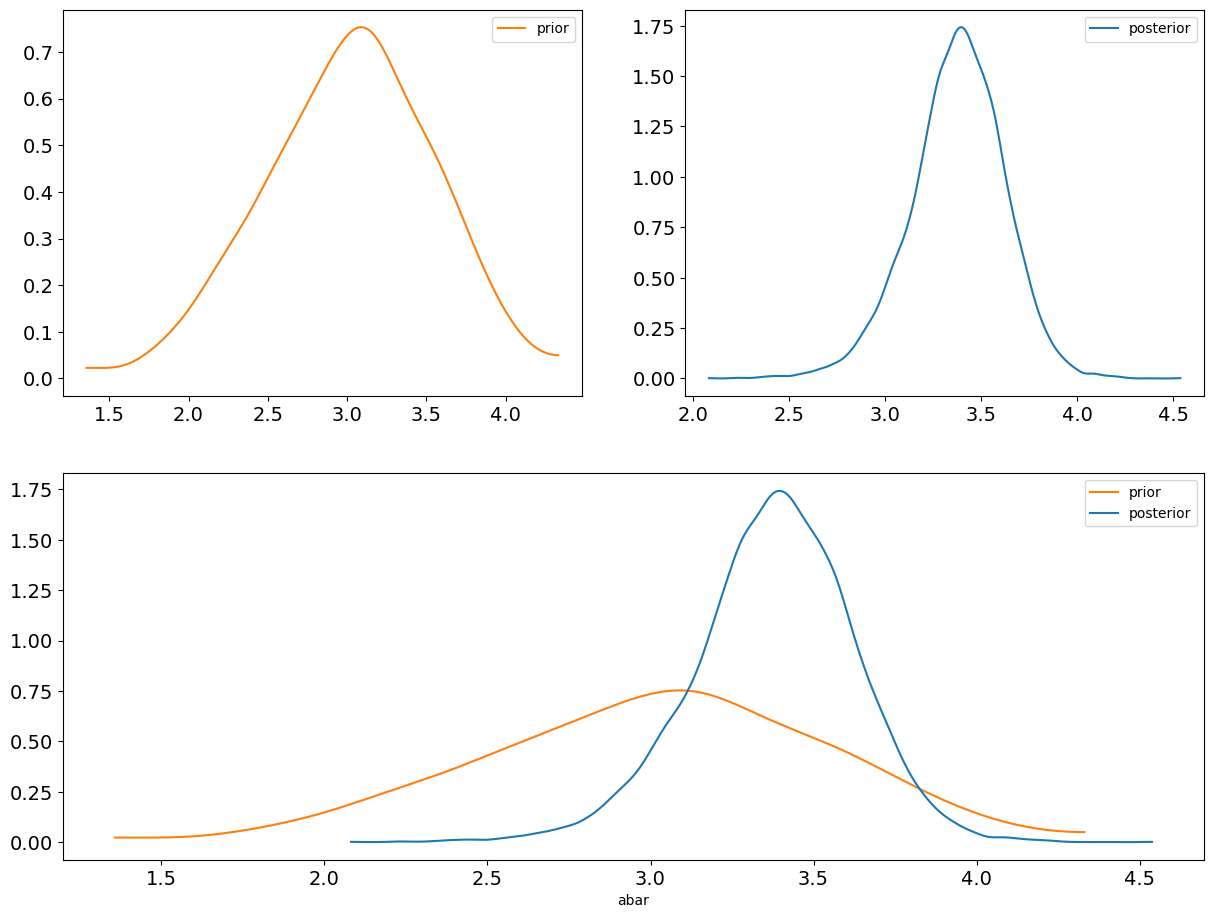

In [16]:
az.plot_dist_comparison(mTdist_trace,var_names=["abar"])

[Text(0.5, 1.0, 'Gaussian process posterior'),
 (-0.1, 2.0),
 Text(0.5, 0, 'distance (thousand km)'),
 Text(0, 0.5, 'covariance')]

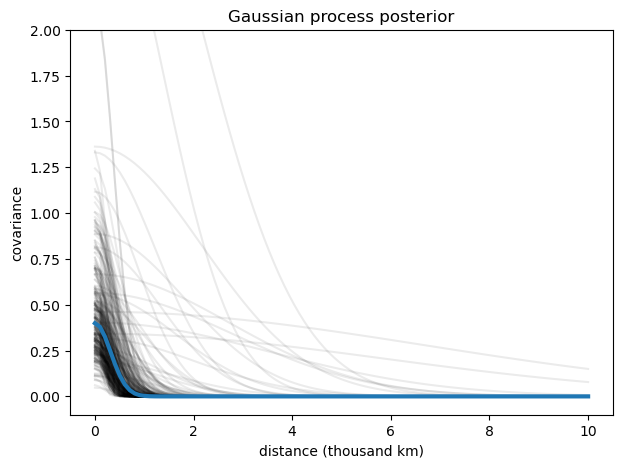

In [19]:
# Adapted from : https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb
# compute posterior median covariance
x_seq = np.linspace(0, 10, 100)
post = mTdist_trace.posterior.stack(sample=("chain", "draw"))
pmcov_mu = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * (x_seq**2))
_, ax = plt.subplots(1, 1, figsize=(7, 5))

# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post["etasq"][::50].values[:, None]
        * np.exp(-post["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu, lw=3)

ax.set(
    title="Gaussian process posterior",
    ylim=(-0.1, 2),
    xlabel="distance (thousand km)",
    ylabel="covariance",
)


## Stratify by Population size now

$T_{i} \sim Poisson(\lambda_i)$

$\lambda_i = \frac{\bar{\alpha}P^{\beta}}{\gamma}exp(\alpha_{S[i]})$

$[\alpha_1,\alpha_2,\alpha_3,...,\alpha_{10}] \sim MVNormal([0,0,0,...,0], K)$

$\bar{\alpha},\beta,\gamma \sim Exponential(1)$

$\eta^2 \sim Exponential(2)$

$\rho^2 \sim Exponential(0.5)$

if $\alpha_{S[i]}$ is 0 (an 'average' island) then $exp(0)$ is 1

In [7]:
P = scale(np.log(kline2.population))
P = P + np.abs(P.min()) + 0.1  # must be > 0, see chp 11

In [84]:
islandsDistMatrix.values.shape

(10, 10)

In [8]:
with pm.Model() as m14_8:
    a = pm.Exponential("a", 1.0)
    b = pm.Exponential("b", 1.0)
    g = pm.Exponential("g", 1.0)
    
    
    T = pm.MutableData('T',kline2['total_tools'].values)
    S = pm.MutableData('S',np.arange(0,10))
    D = pm.MutableData('D',islandsDistMatrix.values)

    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=D)

    lam = (a * P**b / g) * pt.exp(k[S])

    T = pm.Poisson("total_tools", lam, observed=T)

    trace_14_8 = pm.sample(4000, tune=2000, target_accept=0.99)

G:\Statistical_Rethinking\rethinking\Lib\site-packages\pymc\gp\cov.py:99: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g, etasq, ls_inv, k_rotated_]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 544 seconds.


In [9]:
az.summary(trace_14_8, var_names=["~k_rotated_"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.93,1.38,0.04,4.40,0.01,0.01,6869.14,5584.93,1.0
b,0.41,0.14,0.14,0.68,0.00,0.00,5519.19,4456.89,1.0
g,0.07,0.07,0.00,0.17,0.00,0.00,6392.85,5473.20,1.0
etasq,0.27,0.32,0.00,0.81,0.00,0.00,5483.22,7911.64,1.0
ls_inv,1.98,1.61,0.00,4.78,0.04,0.03,1233.58,3858.13,1.0
rhosq,3.25,4.36,0.00,11.43,0.10,0.07,1233.58,3858.13,1.0
k[0],0.07,0.46,-0.79,0.93,0.01,0.00,7714.00,8025.80,1.0
k[1],0.02,0.41,-0.76,0.74,0.00,0.00,9533.11,8445.22,1.0
k[2],-0.04,0.39,-0.77,0.66,0.00,0.00,10465.76,6201.07,1.0
k[3],0.25,0.40,-0.47,0.96,0.00,0.00,10099.94,6864.51,1.0


C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_9632\394716044.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(


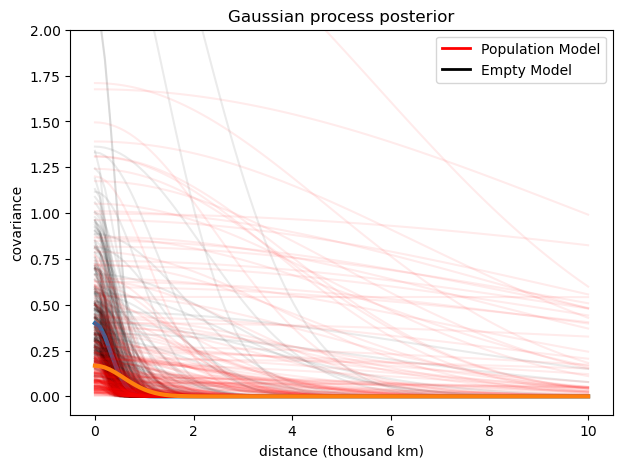

In [23]:
# Adapted from : https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb
# compute posterior median covariance

_, ax = plt.subplots(1, 1, figsize=(7, 5))
#Empty model
x_seq = np.linspace(0, 10, 100)
post = mTdist_trace.posterior.stack(sample=("chain", "draw"))
pmcov_mu = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * (x_seq**2))


# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post["etasq"][::50].values[:, None]
        * np.exp(-post["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
    label='Empty Model'
    
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu, lw=3)


#Population Model

x_seq = np.linspace(0, 10, 100)
post = trace_14_8.posterior.stack(sample=("chain", "draw"))
pmcov_mu = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * (x_seq**2))
# plot functions sampled from posterior
ax.plot(
    x_seq,
    (
        post["etasq"][::50].values[:, None]
        * np.exp(-post["rhosq"][::50].values[:, None] * (x_seq**2))
    ).T,
    "k",
    alpha=0.08,
    color='red',
    label='Population Model'
)

# plot median covariance function
ax.plot(x_seq, pmcov_mu, lw=3)

ax.set(
    title="Gaussian process posterior",
    ylim=(-0.1, 2),
    xlabel="distance (thousand km)",
    ylabel="covariance",
)

legend_elements = [    plt.Line2D([0], [0], color='red', lw=2),
    plt.Line2D([0], [0], color='black', lw=2)
]
ax.legend(legend_elements, ['Population Model', 'Empty Model'])


## Phylogenetic Regression

data(Primates301)

LIfe history traits

Mass g, brain cc, group size

Much missing data, measurement error, unobserved confounding

In [24]:
prim = pd.read_csv('Data/Primates301.csv',sep=';')
prim.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


In [28]:
#Filter prim for only where we get all 3 values 
cols = ['brain','body','group_size']
primnan = prim.loc[~prim[cols].isnull().any(axis=1)]
primnan

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.0,40.00,NaN,106.15,276.0,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.0,7.40,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.0,8.90,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.0,7.40,NaN,NaN,NaN,NaN,NaN
5,Alouatta_palliata,Alouatta,palliata,NaN,6,3,3.0,79.0,49.88,6250.0,13.10,185.42,495.60,300.0,1578.42,681.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,Trachypithecus_obscurus,Trachypithecus,obscurus,NaN,295,67,0.0,6.0,62.12,7056.0,10.00,146.63,362.93,300.0,NaN,509.56
295,Trachypithecus_phayrei,Trachypithecus,phayrei,NaN,296,67,0.0,16.0,72.84,7475.0,12.90,180.61,305.87,NaN,NaN,486.48
296,Trachypithecus_pileatus,Trachypithecus,pileatus,NaN,297,67,0.0,5.0,103.64,11794.0,8.50,NaN,NaN,NaN,NaN,NaN
298,Trachypithecus_vetulus,Trachypithecus,vetulus,NaN,299,67,0.0,2.0,61.29,6237.0,8.35,204.72,245.78,276.0,1113.70,450.50


## Causal Salad in Evolutionary Ecology

Phylogenetic comparative methods dominated by causal salad

Causal salad: tossing factors into regression and interpreting every coefficient as causal

"Controlling for phylogeny": Required but mindless

Regression + phylogeny still requires causal model


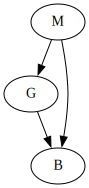

In [30]:
b = graphviz.Digraph()
b.edge('G','B')
b.edge('M','G')
b.edge('M','B')
b
# G = Group size, B = Brain size, M = Mass

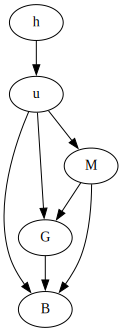

In [33]:
b = graphviz.Digraph()
b.edge('G','B')
b.edge('M','G')
b.edge('M','B')
b.edge('u','B')
b.edge('u','M')
b.edge('u','G')
b.edge('h','u')
b
#u is unobserved confound
#h is history

Two conjoint problems

1) What is the history (phylogeny)?

Gotten much better with genomics BUT

Problems: Huge uncertainty in best case, process not stationary, no one philogeny correct for all traits

Cultural/linguistic phylogenies unconvincing, need new inference tools

Basic truth: Phylogenies do not exist, trying to regularize, it's a latent construction. 

2) How to use it to model causes?

Suppose we have a phylogeny. Now what?

No universally correct approach

Default approach is a Gaussian process regression (phylogenies as 'distances' between species

Start with an ordinary linear regression, trying to estimate the causal effect of G on B. Have to stratify by M

$B_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha +\beta_GG_i+ \beta_MM_i$

$\alpha \sim Normal(0,1)$

$\beta_G,\beta_M \sim Normal(0,0.5)$

$\sigma \sim Exponential(1)$

Can **ALWAYS** reexpress a linear regression with a Normal distribution assigned to individual outcome, with a MultiVariateNormal. 

$B \sim MVNormal(\mu,K)$

$\mu_i = \alpha +\beta_GG_i+ \beta_MM_i$

$K = I\sigma^2$ #Covariance matrix, I is identity matrix

$\alpha \sim Normal(0,1)$

$\beta_G,\beta_M \sim Normal(0,0.5)$

$\sigma \sim Exponential(1)$

In [41]:
#Ordinary linear regression
with pm.Model() as mBMGO:
    N_spp = pm.MutableData('N_spp',primnan.shape[0])
    M     = pm.MutableData('M',scale(np.log(primnan['body'])))
    B     = pm.MutableData('B',scale(np.log(primnan['brain'])))
    G     = pm.MutableData('G',scale(np.log(primnan['group_size'])))
    Imat = pm.MutableData('Imat',np.identity(primnan.shape[0]))
    
    sigma = pm.Exponential('sigma',1)
    bM    = pm.Normal('bM',0,0.5)
    bG    = pm.Normal('bG',0,0.5)
    a     = pm.Normal('a' ,0,1)
    
    mu    = pm.Deterministic('mu',a + bM*M + bG*G)
    Bobs  = pm.Normal('Bobs',mu,sigma,observed=B)
    
    mBMGO_trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bG, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


In [44]:
#Multivarite form
with pm.Model() as mBMG:
    N_spp = pm.MutableData('N_spp',primnan.shape[0])
    M     = pm.MutableData('M',scale(np.log(primnan['body'])))
    B     = pm.MutableData('B',scale(np.log(primnan['brain'])))
    G     = pm.MutableData('G',scale(np.log(primnan['group_size'])))
    Imat = pm.MutableData('Imat',np.identity(primnan.shape[0]))
    
    sigma = pm.Exponential('sigma',1)
    bM    = pm.Normal('bM',0,0.5)
    bG    = pm.Normal('bG',0,0.5)
    a     = pm.Normal('a' ,0,1)
    
    K =   pm.Deterministic('K',Imat*(sigma**2)) #Covariance matrix
    
    mu    = pm.Deterministic('mu',a + bM*M + bG*G)
    Bobs  = pm.MvNormal('Bobs',mu,cov=K,observed=B)
    
    mBMG_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bG, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [53]:
az.summary(mBMGO_trace,var_names=['~mu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.893,0.023,0.853,0.940,0.0,0.0,2256.0,2839.0,1.0
bG,0.124,0.023,0.079,0.164,0.0,0.0,2454.0,2637.0,1.0
a,-0.001,0.018,-0.034,0.034,0.0,0.0,4226.0,3220.0,1.0
sigma,0.217,0.013,0.194,0.242,0.0,0.0,3653.0,3105.0,1.0


In [54]:
#Equivalent inference!
az.summary(mBMG_trace,var_names=['~K','~mu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.893,0.023,0.850,0.935,0.0,0.0,2502.0,2759.0,1.0
bG,0.124,0.023,0.081,0.167,0.0,0.0,2674.0,3126.0,1.0
a,-0.000,0.018,-0.036,0.033,0.0,0.0,3645.0,3077.0,1.0
sigma,0.217,0.013,0.193,0.241,0.0,0.0,3912.0,2763.0,1.0


$B \sim MVNormal(\mu,K)$

$\mu_i = \alpha +\beta_GG_i+ \beta_MM_i +u_i$

$K = I\sigma^2$ #Covariance matrix, I is identity matrix

$\alpha \sim Normal(0,1)$

$\beta_G,\beta_M \sim Normal(0,0.5)$

$\sigma \sim Exponential(1)$

## From Model to Kernel

Evolutionary model + tree structure = pattern of covariation at tips

Covariance declines with phylogenetic distance

Phylogenetic distances: Branch length from one species to another 

Common simple models:

- Brownian motion (linear relationship between phylogenetic distance and covariation)

- Ornstein-Uhlenbeck (damped Brownian motion)

$B \sim MVNormal(\mu,K)$

$\mu_i = \alpha$

$K = \eta^2exp(-\rho d_{i,j})$ #Ornstein-Uhlenbeck kernel

$\alpha \sim Normal(0,1)$

$\eta^2 \sim HalfNormal(1,0.25)$ #Maximum covariance prior

$\rho \sim HalfNormal(3,0.25)$ #Rate prior

## GET THE HARDEST PART WORKING FIRST 

In [67]:
parsed = rdata.parser.parse_file('Data/Primates301_distance_matrix.rda')
converted = rdata.conversion.convert(parsed)
Dmat0 = converted['Primates301_distance_matrix']

In [178]:
#Gaussian process form (Ornstein-Uhlenbeck (L1 gaussian process))
# add scaled and reordered distance matrix
with pm.Model() as mB_OU:
    #Data
    N_spp = pm.MutableData('N_spp',primnan.shape[0])
    M     = pm.MutableData('M',scale(np.log(primnan['body'])))
    B     = pm.MutableData('B',scale(np.log(primnan['brain'])).reshape(-1, 1))
    G     = pm.MutableData('G',scale(np.log(primnan['group_size'])))
    Dmat = pm.MutableData('Dmat',
                          (Dmat0[primnan.index,primnan.index]/np.max(Dmat0)).values)
    
    
    #Priors
    etasq = pm.Exponential('etasq',0.25)
    rho = pm.Exponential('rho',0.25)
    a     = pm.Normal('a' ,0,1)
    b     = pm.Normal('b' ,0,1)
    mu    = pm.gp.mean.Linear(coeffs=0,
                              intercept=a,
                              )

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls=rho)
    gp = pm.gp.Marginal(mean_func=mu, cov_func=cov)

    Bobs = gp.marginal_likelihood('Bobs', X=Dmat,y=B,sigma=0) #ALWAYS DOUBLE CHECK 

    # Sample from the posterior
    mB_OU_trace = pm.sample()

G:\Statistical_Rethinking\rethinking\Lib\site-packages\pymc\gp\cov.py:99: UserWarning: Only 1 column(s) out of 151 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [etasq, rho, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


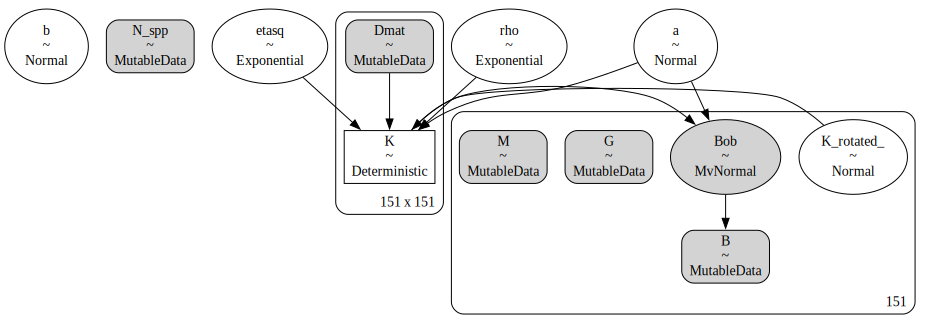

In [171]:
pm.model_to_graphviz(mB_OU)

$B \sim MVNormal(\mu,K)$

$\mu_i = \alpha + \beta_GG_i + \beta_MM_i$

$K = \eta^2exp(-\rho d_{i,j})$ 

$\alpha \sim Normal(0,1)$

$\beta_G,\beta_M \sim Normal(0,0.5)$

$\eta^2 \sim HalfNormal(1,0.25)$ 

$\rho \sim HalfNormal(3,0.25)$ 

In [270]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def __call__(self, X):
        """In the trace summary, b0 will be bM and b1 will be bG"""
        return self.intercept + self.slopes[0] * M + self.slopes[1] * G

#Stratify by M and G now
with pm.Model() as mBMG_OU:
    #Data
    N_spp = pm.MutableData('N_spp',primnan.shape[0])
    M     = pm.MutableData('M',scale(np.log(primnan['body'])))
    B     = pm.MutableData('B',scale(np.log(primnan['brain'])))#.reshape(-1, 1))
    G     = pm.MutableData('G',scale(np.log(primnan['group_size'])))
    Dmat = pm.MutableData('Dmat',
                          (Dmat0[primnan.index,primnan.index]/np.max(Dmat0[primnan.index,primnan.index])).values)
                          
    a     = pm.Normal('a' ,0,1)
    b    = pm.Normal('bM',0,0.5,shape=2)
    mu    = LinearMean(slopes=b,
                       intercept=a
                      )
    #Priors
    etasq = pm.Exponential('etasq',1)
    rhosq = pm.Normal('rhosq',3.0,0.25)
    SIGMA = pm.Exponential('SIGMA',1.0)
                       
    
    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls=rhosq)
    gp = pm.gp.Marginal(mean_func=mu,cov_func=cov)

    Bobs = gp.marginal_likelihood('Bobs', X=Dmat,y=B,sigma=SIGMA) 

    # Sample from the posterior
    
    mBMG_OU_trace = pm.sample(2000, tune=2000, target_accept=0.9)

G:\Statistical_Rethinking\rethinking\Lib\site-packages\pymc\gp\gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
G:\Statistical_Rethinking\rethinking\Lib\site-packages\pymc\gp\cov.py:99: UserWarning: Only 1 column(s) out of 151 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, etasq, rhosq, SIGMA]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 199 seconds.


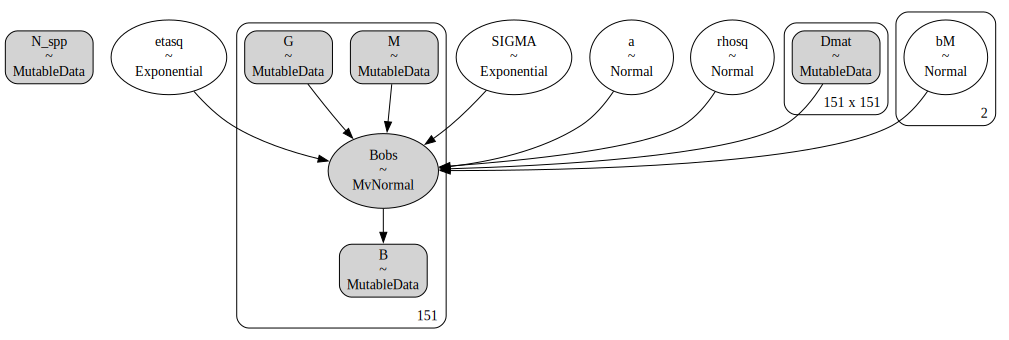

In [271]:
pm.model_to_graphviz(mBMG_OU)

In [272]:
az.summary(mBMG_OU_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.551,-1.119,1.009,0.007,0.007,6690.0,4335.0,1.0
bM[0],0.898,0.022,0.859,0.943,0.000,0.000,5256.0,5316.0,1.0
bM[1],0.116,0.023,0.074,0.160,0.000,0.000,5723.0,5091.0,1.0
rhosq,3.011,0.257,2.536,3.496,0.003,0.002,9149.0,5527.0,1.0
etasq,0.609,0.647,0.008,1.795,0.008,0.005,4705.0,3265.0,1.0
SIGMA,0.213,0.013,0.190,0.237,0.000,0.000,8962.0,5372.0,1.0


Lingering problems:

1) What about phylogenetic uncertainty?

2) Don't these traits influence one another reciprocally over time? 

Regression might be a bad idea for these types of problems. Maybe try something else? 

## Gaussian Processes

Partial pooling for continuous categories

Very general approximation engine

Causal theory => covariance kernel

Sensitivity to kernel priors - choose wisely 